# COMP90051 Project 2

In [48]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod
from sklearn.tree import DecisionTreeClassifier   # for Task 4
from sklearn.base import clone                    # optional for Task 4
import matplotlib.pyplot as plt                   # for Task 5
from sklearn.metrics.pairwise import rbf_kernel   # for Task 6

In [49]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
    """
    def __init__(self, n_arms):
        if not np.issubdtype(type(n_arms), np.integer):
            raise TypeError("`n_arms` must be an integer")
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        # your code here (if you like)
        
    @abstractmethod
    def play(self, context):
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        # your code here (if you like)
    
    @abstractmethod
    def update(self, arm, reward, context):
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None. 
        """
        # your code here (if you like)

In [50]:
# Define global functions here, if required

## 1. Implement ε-greedy and UCB MABs

In [51]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, epsilon, Q0=np.inf):
        super().__init__(n_arms)
        self.tot_rewards=[0]*n_arms
        self.tot_plays=[0]*n_arms
        self.Q0=Q0 
        self.n_arms=n_arms
        self.epsilon=epsilon 
    
    def play(self, t_round, context=None):
        super().play(context)

        if (np.random.random() <= self.epsilon):
            return np.random.randint(1,self.n_arms + 1)
        else:
            best_val=0
            best_arm=[]
            for arm in range(self.n_arms):

                if self.tot_plays[arm]==0:
                    arm_val=self.Q0
                else:
                    arm_val=self.tot_rewards[arm]/self.tot_plays[arm]

                if best_val<arm_val:
                    best_val=arm_val
                    best_arm=[arm]

                if arm_val == best_val:
                    best_arm.append(arm)

            if len(best_arm)==1:
                return best_arm[0]  

            else:
                return np.random.choice(best_arm)  
            
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.tot_rewards[arm]+=reward
        self.tot_plays[arm]+=1

In [52]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        
        self.tot_rewards=[0]*n_arms
        self.tot_plays=[0]*n_arms
        self.Q0=Q0
        self.n_arms=n_arms
        self.rho=rho
                
    def play(self, t_round, context=None):
        super().play(context)
        # used to keep track of the highest value arms
        best_val=0
        best_arm=[]

        for arm in range(self.n_arms):
            if self.tot_plays[arm]==0:
                arm_val=self.Q0
            else:
                ucb=np.sqrt(self.rho*np.log(t_round)/self.tot_plays[arm])
                arm_val=(self.tot_rewards[arm]/self.tot_plays[arm])+ucb
                
            if best_val<arm_val:
                best_val=arm_val
                best_arm=[arm]

            if arm_val==best_val:
                best_arm.append(arm)

        if len(best_arm)==1:
            return best_arm[0] 

        else:
            return np.random.choice(best_arm) 
        
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.tot_rewards[arm]+=reward
        self.tot_plays[arm]+=1

## 2. Implement off-policy evaluation

In [53]:
def offlineEvaluate(mab, arms, rewards, contexts, n_rounds=None):
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : integer numpy.ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float numpy.ndarray, shape (n_events,)
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, default=None
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    rewardList=[]
    t_round=0 
    for i in range(len(contexts)):
        arm=mab.play(t_round,contexts[i])

        if arms[i]==arm:
            rewardList.append(rewards[i])
            mab.update(arms[i],rewards[i],contexts[i])
            t_round += 1
            
        if t_round==n_rounds:
            break          
                
    return rewardList

In [54]:
# load dataset here
data=np.loadtxt('dataset.txt', dtype=int)
arms=data[:,0]
rewards=data[:,1]      
contexts=data[:,2:102]

In [55]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.2675


In [59]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.165


## 3. Implement LinUCB contextual MAB

In [60]:
class LinUCB(MAB):
    """Contextual multi-armed bandit (LinUCB)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    """
    def __init__(self, n_arms, n_dims, alpha):
        super().__init__(n_arms) 
        self.n_arms=n_arms
        self.arms_A=[np.identity(n_dims)]*n_arms 
        self.arms_b=[np.zeros((n_dims,1))]*n_arms
        self.alpha=alpha
           
    def play(self, t_round, context):
        super().play(context)
        arm_context = np.split(context,self.n_arms)
        best_val=float("-inf")
        best_arm=[]

        for arm in range(self.n_arms):
            linucb=self.alpha*np.sqrt([arm_context[arm]]@np.linalg.inv(self.arms_A[arm])@np.transpose([arm_context[arm]]))
            theta_a=np.linalg.inv(self.arms_A[arm])@self.arms_b[arm]
            arm_val=np.transpose(theta_a)@np.transpose([arm_context[arm]])+linucb
                
            if best_val<arm_val:
                best_val=arm_val
                best_arm=[arm]

            if arm_val==best_val:
                best_arm.append(arm)
                
        if len(best_arm)==1:
            return best_arm[0] 

        else:
            return np.random.choice(best_arm)
            
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        arm_context=np.split(context,self.n_arms)
        
        self.arms_A[arm]=self.arms_A[arm]+np.transpose([arm_context[arm]])@[arm_context[arm]] 
        self.arms_b[arm]=self.arms_b[arm]+reward*np.transpose([arm_context[arm]])

In [61]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Implement TreeBootstrap contextual MAB

In [46]:
class TreeBootstrap(MAB):
    """Contextual Thompson sampled multi-armed bandit (TreeBootstrap)

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    tree : instance of sklearn.tree.DecisionTreeClassifier, optional
        Decision tree to use for predicting the expected future reward. 
        Defaults to sklearn.tree.DecisionTreeClassifier().
    """
    def __init__(self, n_arms, n_dims, tree=DecisionTreeClassifier()):
        super().__init__(n_arms)
        self.n_arms=n_arms  
        self.tot_plays=[0]*n_arms
        self.D_ta ={}
        for arm in range(n_arms):
            self.D_ta[arm]=[]
        
    def play(self,t_round, context):
        super().play(context)
        best_val=float("-inf")
        best_arm=[] 
        
        for arm in range(self.n_arms):
            if self.tot_plays[arm]==0:
                arm_val=1
            else:
                target=[]
                inputs=[]
                n=len(self.D_ta[arm])
                for num in range(n):
                    i=np.random.randint(n)
                    bootstrap=self.D_ta[arm][i]
                    target.append(bootstrap[1])
                    split=np.split(bootstrap[2:],self.n_arms)
                    inputs.append(split[arm])
                    
                model=DecisionTreeClassifier()
                model.fit(inputs, target)
                
                arm_context = np.split(context,self.n_arms)
                arm_val=model.predict([arm_context[arm]])
            if best_val<arm_val:
                best_val=arm_val
                best_arm=[arm]
            
            if arm_val==best_val:
                best_arm.append(arm)
                
        if len(best_arm)==1:
            return best_arm[0] 

        else:
            return np.random.choice(best_arm)
            
        
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        a=np.concatenate((arm,reward,context), axis=None)
        self.D_ta[arm].append(a)
        self.tot_plays[arm]+=1
        

In [47]:
mab = TreeBootstrap(10, 10)
results_TreeBootstrap = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('TreeBootstrap average reward', np.mean(results_TreeBootstrap))

TreeBootstrap average reward 0.7


## 5. Evaluation and hyperparameter tuning for LinUCB
### 5.A.

Text(0.5,0,'Round')

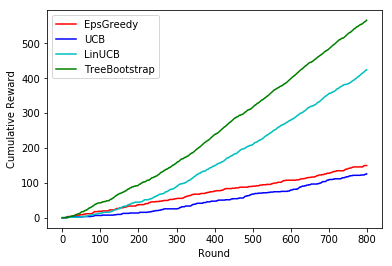

In [65]:
rounds=range(800)

plt.plot(rounds,np.cumsum(results_EpsGreedy),'r', label="EpsGreedy")
plt.plot(rounds,np.cumsum(results_UCB),'b',label="UCB")
plt.plot(rounds,np.cumsum(results_LinUCB),'c',label="LinUCB")
plt.plot(rounds,np.cumsum(results_TreeBootstrap),'g',label="TreeBootstrap")
plt.legend(loc='upper left')
plt.ylabel("Cumulative Reward")
plt.xlabel("Round")

### 5.B.

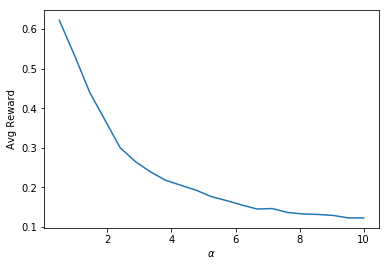

In [67]:
def grid_search(grid):
    list=[]
    for num in grid:
        print(num)
        result=offlineEvaluate(LinUCB(10, 10, num), arms, rewards, contexts, 800)
        result_mean=np.mean(result)
        list.append(result_mean)
        
    plt.plot(grid,list)
    plt.ylabel("Avg Reward")
    plt.xlabel(r'$\alpha$')

grid=np.linspace(0.5,10,21)
grid_search(grid)

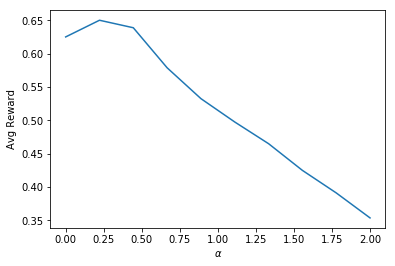

In [224]:
grid=np.linspace(0,2,10)
grid_search(grid)

In [178]:
##This result suggests the optimal alpha is around 0.2

## 6. Implement KernelUCB contextual MAB

In [ ]:
class KernelUCB(MAB):
    """Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    gamma : float
        Positive real explore-exploit parameter.
    
    eta : float
        Positive real explore-exploit parameter.
    
    kern : callable
        A kernel function from sklearn.metrics.pairwise.
    """
    def __init__(self, n_arms, n_dims, gamma, eta, kern):
        super().__init__(n_arms)
        # your code here
        
    def play(self, context):
        super().play(context)
        # your code here
    
    def update(self, arm, reward, context):
        super().update(arm, reward, context)
        # your code here

In [ ]:
mab = KernelUCB(10, 10, 1.0, 0.1, rbf_kernel)
results_KernelUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('KernelUCB average reward', np.mean(results_KernelUCB))

In [ ]:
# your plotting code here